In [1]:
import tensorflow as tf
print(tf.__version__)

C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\ten

1.10.0


In [2]:
from agents.BinaryStateAgent import BinaryStateAgent
from agents.MemoryBuffer import MemoryBuffer
from agents.NeuralNetwork import NeuralNetwork
from environment.Simulator import Simulator
from environment.BinaryStateEnvironment import BinaryStateEnvironment
from environment.Config import ConfigTimeSeries
from environment.BaseEnvironment import TimeSeriesEnvironment

#tf.compat.v1.disable_eager_execution()
config = ConfigTimeSeries()
env = BinaryStateEnvironment(
    TimeSeriesEnvironment(verbose=True, filename="./Test/SmallData.csv", config=config))
dqn = NeuralNetwork(input_dim=2,
                    input_neurons=2 + 1).keras_model
agent = BinaryStateAgent(dqn=dqn, memory=MemoryBuffer(max=50000, id="binary_agent"), alpha=0.0001, gamma=0.9, \
                         epsilon=1.0, epsilon_end=0.0, epsilon_decay=0.9, fit_epoch=2, action_space=2, \
                         batch_size=512)

TimeSeries from: ./Test/SmallData.csv
 Header(labeled):
    value  anomaly
0  12183        0
1  12715        0
2  12736        0 
Header(unlabeled):
    value
0  12183
1  12715
2  12736 
Rows:
 1439
MeanValue:
 11020.08
MaxValue:
 170029
MinValue:
 3594
Successfully stored to memory_binary_agent.obj
Memory is full, 5000 Samples stored. It took 0.3420860767364502 seconds
Training episode 0 took 0.6981372833251953 seconds Update Target Model
Training episode 1 took 0.17250728607177734 seconds 
Training episode 2 took 0.19348716735839844 seconds 
Training episode 3 took 0.2104334831237793 seconds 
Training episode 4 took 0.22539758682250977 seconds 
Training episode 5 took 0.2513554096221924 seconds Update Target Model
Training episode 6 took 0.2532973289489746 seconds 
Training episode 7 took 0.282243013381958 seconds 
Training episode 8 took 0.30216503143310547 seconds 
Training episode 9 took 0.3151681423187256 seconds 
Testing episode 10 took 0.3670082092285156 seconds


C:\Users\nils\Anaconda3\envs\master2020\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


<Figure size 1500x700 with 1 Axes>

True

Successfully loaded Object from memory_binary_agent.obj
Training episode 0 took 0.424863338470459 seconds Update Target Model
Training episode 1 took 0.4348413944244385 seconds 
Training episode 2 took 0.4258577823638916 seconds 
Training episode 3 took 0.39594221115112305 seconds 
Training episode 4 took 0.4068872928619385 seconds 
Training episode 5 took 0.40192484855651855 seconds Update Target Model
Training episode 6 took 0.4189145565032959 seconds 
Training episode 7 took 0.43384647369384766 seconds 
Training episode 8 took 0.4108750820159912 seconds 
Training episode 9 took 0.47672557830810547 seconds 
Testing episode 10 took 0.4079101085662842 seconds


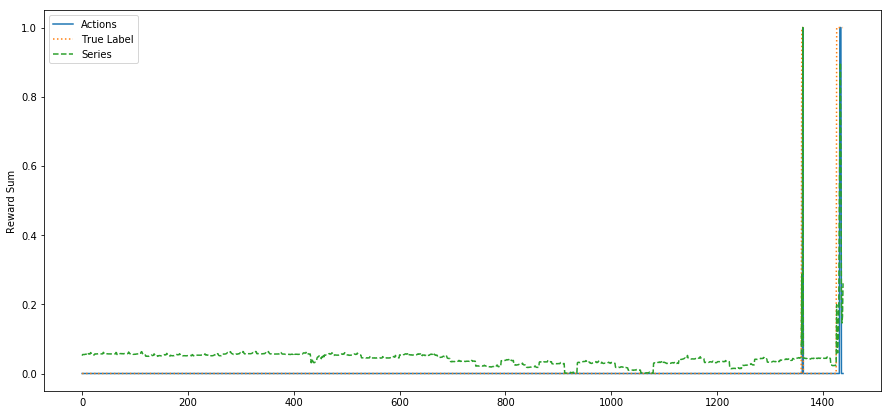

True

In [3]:
simulation = Simulator(10, agent, env, 5)
agent.memory.init_memory(env=env)
simulation.run()